# Deep Learning TP1: Introduction to Keras

# 1) Introduction

## Import packages

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import keras
import io
from keras import utils
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.layers import Flatten
import matplotlib.patches as patches
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Provided functions : Image generator

In [3]:

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in tqdm(range(nb_samples),'Creating Data'):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3)
    #np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in tqdm(range(nb_samples),'Creating data'):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

def display_multiple_graphs(model,X,Y,X_reshaped,comment=''):
    fig, ax = plt.subplots(20,5, figsize=(30,100))
    for i in tqdm(range(100), desc='Plotting'+comment+' images with free location'):
        x, q, r = X[i], i//5, i%5
        ax[q, r].imshow(x.reshape((IMAGE_SIZE,IMAGE_SIZE)),extent=[-0.15,1.15,-0.15,1.15], cmap='gray')
        ax[q, r].set_xlim([0,1]); ax[q, r].set_ylim([0,1])
        xy = Y[i].reshape(3,2)
        xy_pred=model.predict(np.array([X_reshaped[i]])).reshape(3,2)
        tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'g', linewidth = 5, alpha = 0.5)
        tri_pred = patches.Polygon(xy_pred, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
        ax[q, r].add_patch(tri); ax[q, r].add_patch(tri_pred)
    plt.show()

### Simple tests

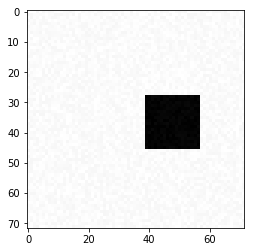

In [3]:
im = generate_a_rectangle(10,True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

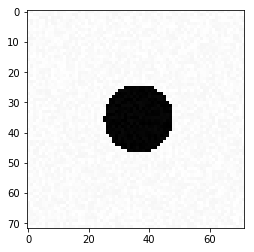

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

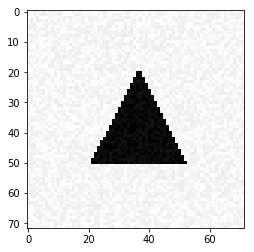

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## Generate Data

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating Data: 100%|█████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 80.34it/s]


# 2) Simple Classification

In [7]:
Y_train = keras.utils.to_categorical(Y_train, 3)
print(Y_train.shape)
# Square=[1,0,0], circle=[0,1,0], triangle=[0,0,1]

(300, 3)


In [8]:
first_model = Sequential()
first_model.add(Dense(3,input_shape=X_train[0].shape))
first_model.add(Activation('softmax'))

In [9]:
first_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


### SGD optimizer

In [10]:
first_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.0001), metrics = ['accuracy'])
first_model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - ETA: 1s - loss: 1.4963 - acc: 0.375 - 0s 1ms/step - loss: 1.4128 - acc: 0.2963 - val_loss: 1.1468 - val_acc: 0.2667
Epoch 2/100
270/270 [==============================] - ETA: 0s - loss: 1.1425 - acc: 0.437 - 0s 167us/step - loss: 1.1019 - acc: 0.3222 - val_loss: 1.0128 - val_acc: 0.5667
Epoch 3/100
270/270 [==============================] - ETA: 0s - loss: 1.0658 - acc: 0.500 - 0s 141us/step - loss: 1.0345 - acc: 0.4778 - val_loss: 0.9696 - val_acc: 0.6333
Epoch 4/100
270/270 [==============================] - ETA: 0s - loss: 0.9606 - acc: 0.531 - 0s 130us/step - loss: 1.0167 - acc: 0.4852 - val_loss: 0.9552 - val_acc: 0.6000
Epoch 5/100
270/270 [==============================] - ETA: 0s - loss: 1.0096 - acc: 0.375 - 0s 122us/step - loss: 1.0044 - acc: 0.4963 - val_loss: 0.9348 - val_acc: 0.6667
Epoch 6/100
270/270 [==============================] - ETA: 0s - loss: 0.9675 - acc: 0.531 -

Epoch 48/100
270/270 [==============================] - ETA: 0s - loss: 0.7384 - acc: 0.718 - 0s 107us/step - loss: 0.7575 - acc: 0.7074 - val_loss: 0.6663 - val_acc: 0.7667
Epoch 49/100
270/270 [==============================] - ETA: 0s - loss: 0.7222 - acc: 0.718 - 0s 119us/step - loss: 0.7514 - acc: 0.6963 - val_loss: 0.6607 - val_acc: 0.7667
Epoch 50/100
270/270 [==============================] - ETA: 0s - loss: 0.7398 - acc: 0.656 - 0s 119us/step - loss: 0.7487 - acc: 0.7037 - val_loss: 0.6645 - val_acc: 0.7667
Epoch 51/100
270/270 [==============================] - ETA: 0s - loss: 0.7744 - acc: 0.687 - 0s 117us/step - loss: 0.7450 - acc: 0.7185 - val_loss: 0.6596 - val_acc: 0.7667
Epoch 52/100
270/270 [==============================] - ETA: 0s - loss: 0.6817 - acc: 0.750 - 0s 119us/step - loss: 0.7447 - acc: 0.7000 - val_loss: 0.6507 - val_acc: 0.7667
Epoch 53/100
270/270 [==============================] - ETA: 0s - loss: 0.7504 - acc: 0.656 - 0s 119us/step - loss: 0.7380 - acc: 

In [11]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(first_model.predict(X_test))

X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
print(first_model.predict(X_test))

X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
print(first_model.predict(X_test))

[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]


We see that at the end of the execution the accuracy on the train set is 100\%. On our simple test all predictions are accurate too.

### ADAM optimizer

In [12]:
first_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
first_model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - ETA: 1s - loss: 0.5693 - acc: 0.906 - 0s 980us/step - loss: 1.3193 - acc: 0.6444 - val_loss: 1.0183 - val_acc: 0.6000
Epoch 2/100
270/270 [==============================] - ETA: 0s - loss: 1.0835 - acc: 0.343 - 0s 156us/step - loss: 0.6460 - acc: 0.7074 - val_loss: 0.6436 - val_acc: 0.6667
Epoch 3/100
270/270 [==============================] - ETA: 0s - loss: 0.2820 - acc: 0.875 - 0s 141us/step - loss: 0.4986 - acc: 0.7926 - val_loss: 0.3439 - val_acc: 0.7667
Epoch 4/100
270/270 [==============================] - ETA: 0s - loss: 0.4710 - acc: 0.718 - 0s 141us/step - loss: 0.3448 - acc: 0.8926 - val_loss: 0.2393 - val_acc: 1.0000
Epoch 5/100
270/270 [==============================] - ETA: 0s - loss: 0.2616 - acc: 0.937 - 0s 130us/step - loss: 0.3008 - acc: 0.8815 - val_loss: 0.2000 - val_acc: 1.0000
Epoch 6/100
270/270 [==============================] - ETA: 0s - loss: 0.2184 - acc: 1.000

Epoch 48/100
270/270 [==============================] - ETA: 0s - loss: 0.0210 - acc: 1.000 - 0s 167us/step - loss: 0.0209 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 1.0000
Epoch 49/100
270/270 [==============================] - ETA: 0s - loss: 0.0239 - acc: 1.000 - 0s 141us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 1.0000
Epoch 50/100
270/270 [==============================] - ETA: 0s - loss: 0.0248 - acc: 1.000 - 0s 137us/step - loss: 0.0194 - acc: 1.0000 - val_loss: 0.0152 - val_acc: 1.0000
Epoch 51/100
270/270 [==============================] - ETA: 0s - loss: 0.0128 - acc: 1.000 - 0s 137us/step - loss: 0.0199 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 1.0000
Epoch 52/100
270/270 [==============================] - ETA: 0s - loss: 0.0171 - acc: 1.000 - 0s 141us/step - loss: 0.0196 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 53/100
270/270 [==============================] - ETA: 0s - loss: 0.0122 - acc: 1.000 - 0s 141us/step - loss: 0.0182 - acc: 

In [13]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(first_model.predict(X_test))

X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
print(first_model.predict(X_test))

X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
print(first_model.predict(X_test))

[[0. 1. 0.]]
[[1. 0. 0.]]
[[0. 0. 1.]]


The results are quite the same as before.

# 3) Visualization of the solution

In [14]:
weights=first_model.get_weights()
weights

[array([[ 0.00513514,  0.02767007,  0.02284537],
        [-0.02169293,  0.00782677, -0.03218955],
        [-0.00752448, -0.02776569, -0.02114881],
        ...,
        [ 0.02863079, -0.02628078, -0.01372166],
        [ 0.00847346, -0.00587818,  0.03210863],
        [-0.02741595,  0.01929153,  0.01837407]], dtype=float32),
 array([ 0.00287911, -0.00092279, -0.00081932], dtype=float32)]

The figures below plot the weight vector corresponding to each category of figure.

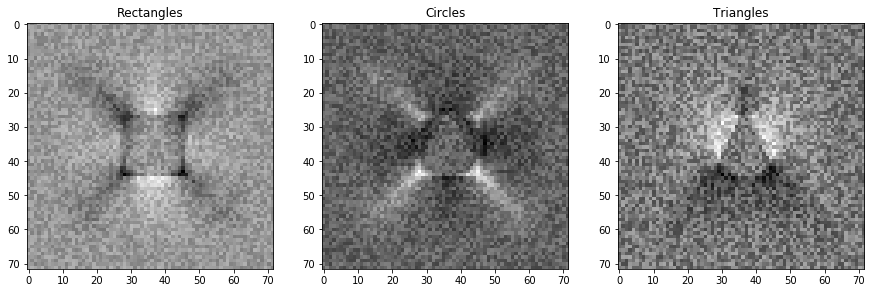

In [15]:
fig,ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(weights[0][:,0].reshape(72,72), cmap='gray')
ax[0].set_title('Rectangles')
ax[1].imshow(weights[0][:,1].reshape(72,72), cmap='gray')
ax[1].set_title('Circles')
ax[2].imshow(weights[0][:,2].reshape(72,72), cmap='gray')
ax[2].set_title('Triangles')
plt.show()

It actually seems like for each geometric figure the net is looking for characteristic points on which it could base its predictions: for squares and triangles it will look at the usual locations of the angles (which is affected by the level of noise), and for circles it will look for points in area which are not filled if the figure is a square or a triangle (basically the angles of a rotation of $\frac{\pi}{4}$ of the square).

On the other hand, it will penalize the "angles" that characterizes the other figures.

# 4) Classification problem with changing location/dimension

In [16]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating Data: 100%|█████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 79.71it/s]


In [17]:
first_model.evaluate(X_test, Y_test)

300/300 [==============================] - ETA:  - 0s 97us/step


[4.197109368642171, 0.3633333325386047]

In [18]:
#For the CNN we add a dimension 'depth'
X_train_reshaped = np.zeros((X_train.shape[0],72,72,1))
for i in range(X_train.shape[0]):
    X_train_reshaped[i,:,:,:] = X_train[i].reshape(72,72,1)
Y_train = keras.utils.to_categorical(Y_train, 3)

In [19]:
CNN_model=Sequential()
CNN_model.add(Conv2D(filters=16,kernel_size=(5,5), activation = 'relu', input_shape=X_train[0].reshape(72,72,1).shape,strides=(2,2)))   
CNN_model.add(MaxPooling2D(pool_size = (2,2)))
CNN_model.add(Flatten())
CNN_model.add(Dense(3, activation = 'softmax')) 

In [20]:
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 34, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4624)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 13875     
Total params: 14,291
Trainable params: 14,291
Non-trainable params: 0
_________________________________________________________________


In [21]:
CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [22]:
CNN_model.fit(X_train_reshaped, Y_train, epochs=100, batch_size=32, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - ETA: 8s - loss: 1.1162 - acc: 0.281 - ETA: 3s - loss: 1.1280 - acc: 0.312 - ETA: 1s - loss: 1.1104 - acc: 0.307 - ETA: 1s - loss: 1.1039 - acc: 0.308 - ETA: 0s - loss: 1.0988 - acc: 0.318 - ETA: 0s - loss: 1.0906 - acc: 0.348 - ETA: 0s - loss: 1.0795 - acc: 0.364 - ETA: 0s - loss: 1.0747 - acc: 0.384 - ETA: 0s - loss: 1.0667 - acc: 0.398 - ETA: 0s - loss: 1.0593 - acc: 0.414 - 1s 1ms/step - loss: 1.0529 - acc: 0.4278 - val_loss: 0.9747 - val_acc: 0.5800
Epoch 2/100
900/900 [==============================] - ETA: 0s - loss: 0.8544 - acc: 0.656 - ETA: 0s - loss: 1.0093 - acc: 0.484 - ETA: 0s - loss: 1.0026 - acc: 0.459 - ETA: 0s - loss: 0.9847 - acc: 0.524 - ETA: 0s - loss: 0.9675 - acc: 0.562 - ETA: 0s - loss: 0.9639 - acc: 0.562 - ETA: 0s - loss: 0.9596 - acc: 0.562 - ETA: 0s - loss: 0.9465 - acc: 0.578 - ETA: 0s - loss: 0.9386 - acc: 0.602 - ETA: 0s - loss: 0.9370 - acc: 0.603 - 1s 678

Epoch 32/100
900/900 [==============================] - ETA: 0s - loss: 0.1719 - acc: 0.968 - ETA: 0s - loss: 0.2303 - acc: 0.921 - ETA: 0s - loss: 0.2056 - acc: 0.942 - ETA: 0s - loss: 0.1903 - acc: 0.963 - ETA: 0s - loss: 0.1987 - acc: 0.963 - ETA: 0s - loss: 0.2014 - acc: 0.961 - ETA: 0s - loss: 0.2043 - acc: 0.958 - ETA: 0s - loss: 0.1980 - acc: 0.961 - ETA: 0s - loss: 0.1991 - acc: 0.957 - ETA: 0s - loss: 0.2057 - acc: 0.954 - 1s 661us/step - loss: 0.2052 - acc: 0.9544 - val_loss: 0.3064 - val_acc: 0.9000
Epoch 33/100
900/900 [==============================] - ETA: 0s - loss: 0.1610 - acc: 0.906 - ETA: 0s - loss: 0.1942 - acc: 0.943 - ETA: 0s - loss: 0.2048 - acc: 0.937 - ETA: 0s - loss: 0.1944 - acc: 0.946 - ETA: 0s - loss: 0.1836 - acc: 0.954 - ETA: 0s - loss: 0.1767 - acc: 0.959 - ETA: 0s - loss: 0.1840 - acc: 0.955 - ETA: 0s - loss: 0.1868 - acc: 0.956 - ETA: 0s - loss: 0.1898 - acc: 0.957 - 1s 628us/step - loss: 0.1951 - acc: 0.9544 - val_loss: 0.3149 - val_acc: 0.8700
Epoch 

900/900 [==============================] - ETA: 0s - loss: 0.0797 - acc: 0.968 - ETA: 0s - loss: 0.1279 - acc: 0.992 - ETA: 0s - loss: 0.1216 - acc: 0.995 - ETA: 0s - loss: 0.1164 - acc: 0.984 - ETA: 0s - loss: 0.1222 - acc: 0.978 - ETA: 0s - loss: 0.1179 - acc: 0.980 - ETA: 0s - loss: 0.1187 - acc: 0.980 - ETA: 0s - loss: 0.1142 - acc: 0.983 - ETA: 0s - loss: 0.1107 - acc: 0.985 - ETA: 0s - loss: 0.1102 - acc: 0.984 - 1s 697us/step - loss: 0.1100 - acc: 0.9844 - val_loss: 0.2561 - val_acc: 0.9100
Epoch 49/100
900/900 [==============================] - ETA: 0s - loss: 0.1322 - acc: 1.000 - ETA: 0s - loss: 0.0967 - acc: 0.992 - ETA: 0s - loss: 0.1237 - acc: 0.973 - ETA: 0s - loss: 0.1213 - acc: 0.971 - ETA: 0s - loss: 0.1206 - acc: 0.973 - ETA: 0s - loss: 0.1157 - acc: 0.976 - ETA: 0s - loss: 0.1151 - acc: 0.975 - ETA: 0s - loss: 0.1131 - acc: 0.977 - ETA: 0s - loss: 0.1099 - acc: 0.980 - ETA: 0s - loss: 0.1091 - acc: 0.979 - 1s 697us/step - loss: 0.1086 - acc: 0.9800 - val_loss: 0.2532

Epoch 64/100
900/900 [==============================] - ETA: 0s - loss: 0.0550 - acc: 1.000 - ETA: 0s - loss: 0.0725 - acc: 0.992 - ETA: 0s - loss: 0.0608 - acc: 0.995 - ETA: 0s - loss: 0.0677 - acc: 0.990 - ETA: 0s - loss: 0.0654 - acc: 0.992 - ETA: 0s - loss: 0.0623 - acc: 0.993 - ETA: 0s - loss: 0.0611 - acc: 0.994 - ETA: 0s - loss: 0.0601 - acc: 0.995 - ETA: 0s - loss: 0.0592 - acc: 0.994 - ETA: 0s - loss: 0.0581 - acc: 0.995 - 1s 646us/step - loss: 0.0575 - acc: 0.9956 - val_loss: 0.2442 - val_acc: 0.8900
Epoch 65/100
900/900 [==============================] - ETA: 0s - loss: 0.0394 - acc: 1.000 - ETA: 0s - loss: 0.0586 - acc: 0.992 - ETA: 0s - loss: 0.0592 - acc: 0.994 - ETA: 0s - loss: 0.0658 - acc: 0.996 - ETA: 0s - loss: 0.0629 - acc: 0.997 - ETA: 0s - loss: 0.0621 - acc: 0.998 - ETA: 0s - loss: 0.0592 - acc: 0.998 - ETA: 0s - loss: 0.0579 - acc: 0.995 - ETA: 0s - loss: 0.0569 - acc: 0.996 - ETA: 0s - loss: 0.0588 - acc: 0.995 - 1s 662us/step - loss: 0.0598 - acc: 0.9944 - val

Epoch 80/100
900/900 [==============================] - ETA: 0s - loss: 0.0225 - acc: 1.000 - ETA: 0s - loss: 0.0335 - acc: 1.000 - ETA: 0s - loss: 0.0386 - acc: 1.000 - ETA: 0s - loss: 0.0327 - acc: 1.000 - ETA: 0s - loss: 0.0328 - acc: 1.000 - ETA: 0s - loss: 0.0331 - acc: 1.000 - ETA: 0s - loss: 0.0358 - acc: 1.000 - ETA: 0s - loss: 0.0354 - acc: 1.000 - ETA: 0s - loss: 0.0360 - acc: 1.000 - ETA: 0s - loss: 0.0353 - acc: 1.000 - 1s 653us/step - loss: 0.0355 - acc: 1.0000 - val_loss: 0.2416 - val_acc: 0.9100
Epoch 81/100
900/900 [==============================] - ETA: 0s - loss: 0.0332 - acc: 1.000 - ETA: 0s - loss: 0.0238 - acc: 1.000 - ETA: 0s - loss: 0.0253 - acc: 1.000 - ETA: 0s - loss: 0.0283 - acc: 1.000 - ETA: 0s - loss: 0.0286 - acc: 1.000 - ETA: 0s - loss: 0.0282 - acc: 1.000 - ETA: 0s - loss: 0.0279 - acc: 1.000 - ETA: 0s - loss: 0.0285 - acc: 1.000 - ETA: 0s - loss: 0.0272 - acc: 1.000 - ETA: 0s - loss: 0.0290 - acc: 1.000 - 1s 673us/step - loss: 0.0292 - acc: 1.0000 - val

Epoch 96/100
900/900 [==============================] - ETA: 0s - loss: 0.0144 - acc: 1.000 - ETA: 0s - loss: 0.0206 - acc: 1.000 - ETA: 0s - loss: 0.0169 - acc: 1.000 - ETA: 0s - loss: 0.0202 - acc: 1.000 - ETA: 0s - loss: 0.0188 - acc: 1.000 - ETA: 0s - loss: 0.0184 - acc: 1.000 - ETA: 0s - loss: 0.0185 - acc: 1.000 - ETA: 0s - loss: 0.0191 - acc: 1.000 - ETA: 0s - loss: 0.0189 - acc: 1.000 - ETA: 0s - loss: 0.0188 - acc: 1.000 - 1s 645us/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.2240 - val_acc: 0.9200
Epoch 97/100
900/900 [==============================] - ETA: 0s - loss: 0.0326 - acc: 1.000 - ETA: 0s - loss: 0.0233 - acc: 1.000 - ETA: 0s - loss: 0.0260 - acc: 1.000 - ETA: 0s - loss: 0.0227 - acc: 1.000 - ETA: 0s - loss: 0.0228 - acc: 1.000 - ETA: 0s - loss: 0.0218 - acc: 1.000 - ETA: 0s - loss: 0.0208 - acc: 1.000 - ETA: 0s - loss: 0.0198 - acc: 1.000 - ETA: 0s - loss: 0.0194 - acc: 1.000 - ETA: 0s - loss: 0.0188 - acc: 1.000 - 1s 647us/step - loss: 0.0189 - acc: 1.0000 - val

In [23]:
X_test_reshaped = np.zeros((X_test.shape[0],72,72,1))
for i in range(X_test.shape[0]):
    X_test_reshaped[i,:,:,:] = X_test[i].reshape(72,72,1)

In [24]:
CNN_model.evaluate(X_test_reshaped, Y_test)

300/300 [==============================] - ETA:  - ETA:  - 0s 297us/step


[0.36142910401026407, 0.8966666658719381]

# 5) Regression Problem

In [58]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)

Creating data: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 94.71it/s]


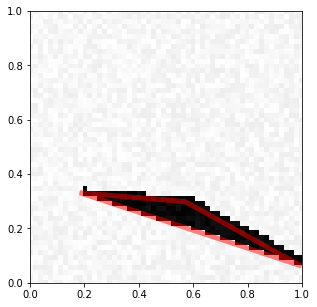

In [59]:
visualize_prediction(X_train[100], Y_train[100])

In [60]:
X_train_reshaped = np.zeros((X_train.shape[0],72,72,1))
for i in range(X_train.shape[0]):
    X_train_reshaped[i,:,:,:] = X_train[i].reshape(72,72,1)

In [61]:
Y_train[100]

array([0.18284753, 0.33132555, 0.5709715 , 0.2984762 , 0.99863364,
       0.06190867])

In [62]:
def normalize_output(y):
    y_out = y.reshape((3,2))
    return y_out[y_out[:,0].argsort()].flatten()

Y_train_out = np.apply_along_axis(normalize_output,1,Y_train)

In [63]:
INPUT_DIM = X_train_reshaped[0].shape
INPUT_SHAPE = (INPUT_DIM[0], INPUT_DIM[1], 1)

reg_model = Sequential()
reg_model.add(Conv2D(16, (5, 5), activation='relu', input_shape=INPUT_SHAPE))
reg_model.add(MaxPooling2D(pool_size=(2, 2)))
reg_model.add(Conv2D(16, (3, 3), activation='relu'))
reg_model.add(MaxPooling2D(pool_size=(2, 2)))
reg_model.add(Conv2D(16, (3, 3), activation='relu'))
reg_model.add(MaxPooling2D(pool_size=(2, 2)))
reg_model.add(Flatten())
reg_model.add(Dense(6, activation = 'linear'))
reg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
__________

In [64]:
reg_model.compile(optimizer='adam',loss='mean_absolute_error')

In [95]:
reg_model.fit(X_train_reshaped, Y_train_out, epochs=20, batch_size=32, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - ETA: 2s - loss: 0.098 - ETA: 2s - loss: 0.094 - ETA: 2s - loss: 0.095 - ETA: 2s - loss: 0.094 - ETA: 2s - loss: 0.092 - ETA: 2s - loss: 0.094 - ETA: 2s - loss: 0.095 - ETA: 2s - loss: 0.094 - ETA: 2s - loss: 0.094 - ETA: 1s - loss: 0.095 - ETA: 1s - loss: 0.096 - ETA: 1s - loss: 0.096 - ETA: 1s - loss: 0.096 - ETA: 1s - loss: 0.096 - ETA: 1s - loss: 0.096 - ETA: 1s - loss: 0.096 - ETA: 1s - loss: 0.095 - ETA: 1s - loss: 0.095 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.094 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.095 - 3s 3ms/step - loss: 0.0958 - val_loss: 0.1112
Epoch 2/20
900/900 [==============================] - ETA: 2s - loss: 0.098 - ETA: 2s - loss: 0.095 - ETA: 2s - loss: 0.098 - ETA: 2s - loss: 0.097 - ETA: 2s - loss: 0.095 - ETA: 2s 

In [96]:
[X_test, Y_test] = generate_test_set_regression()

Creating data: 100%|█████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 81.63it/s]


In [97]:
Y_test_out=np.apply_along_axis(normalize_output,1,Y_test)

In [98]:
X_test_reshaped = np.zeros((X_test.shape[0],72,72,1))
for i in range(X_test.shape[0]):
    X_test_reshaped[i,:,:,:] = X_test[i].reshape(72,72,1)

In [99]:
model.evaluate(X_test_reshaped, Y_test_nor)

300/300 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step


0.03358196596304575

Plotting images with free location: 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 215.17it/s]


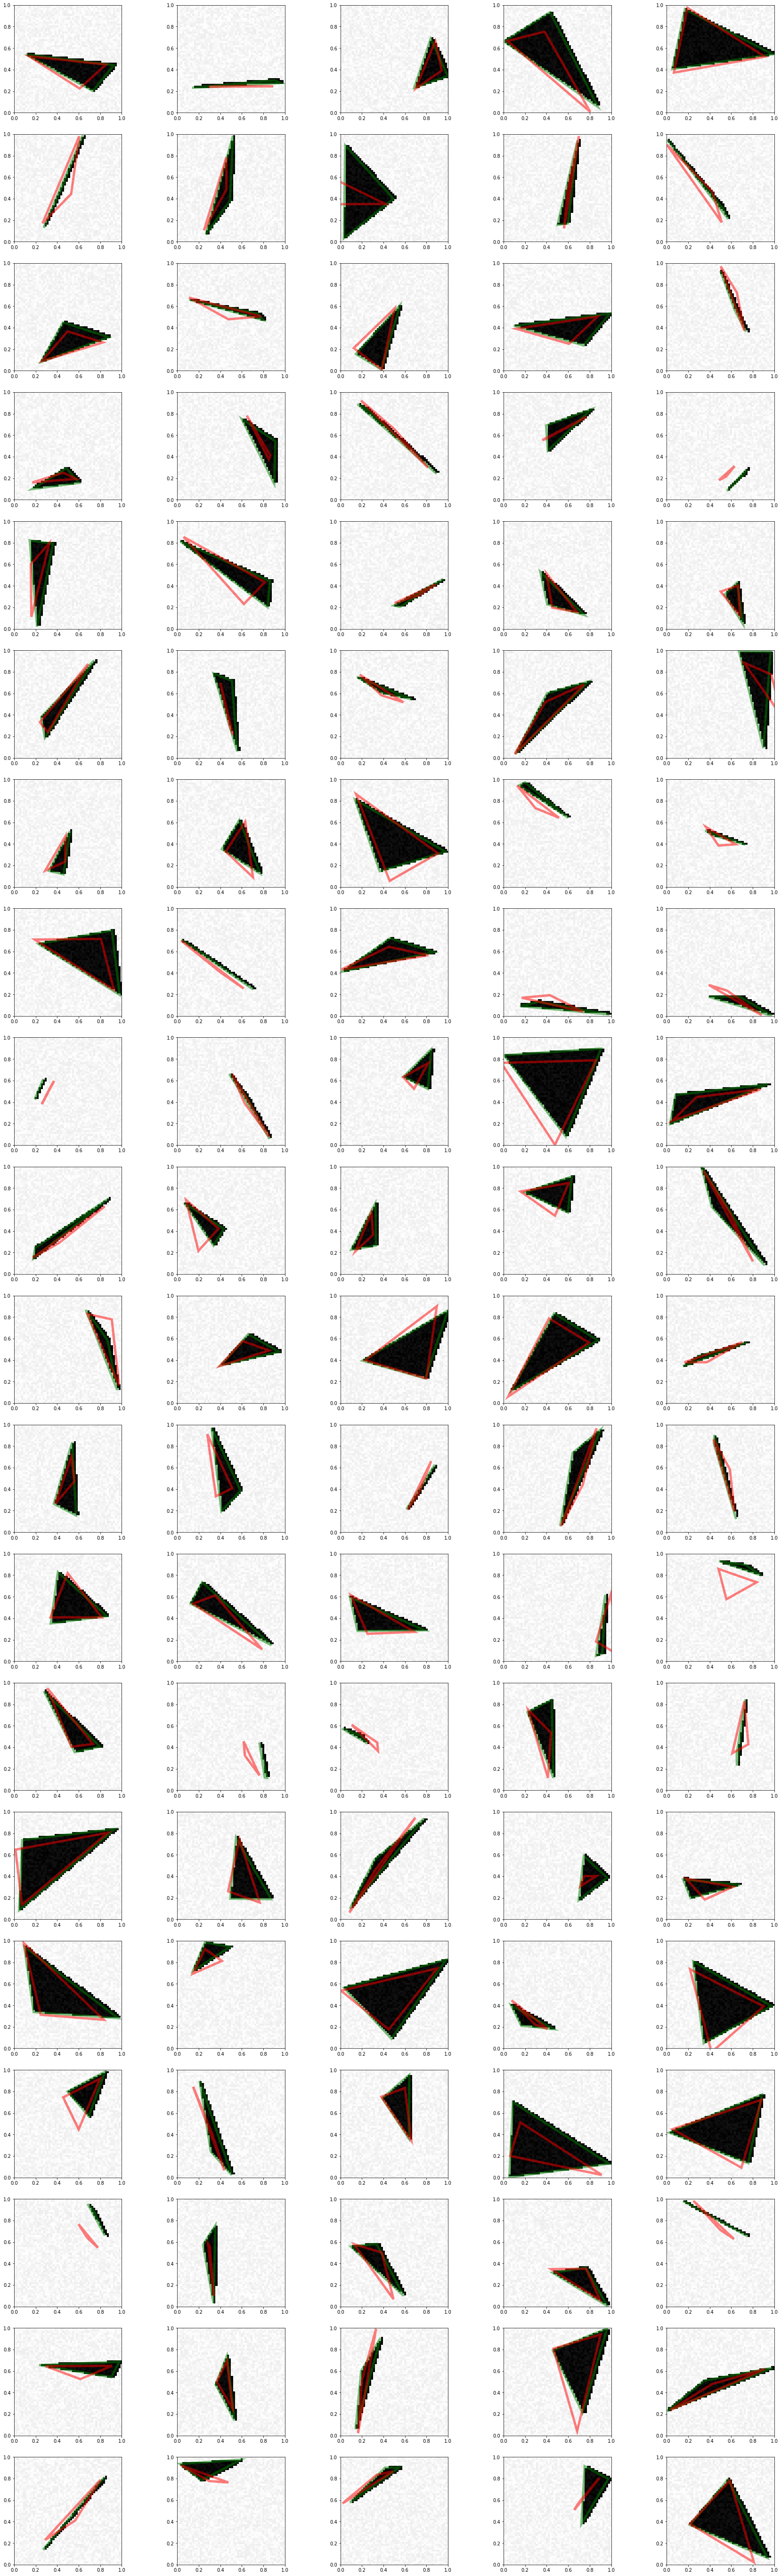

In [100]:
display_multiple_graphs(reg_model,X_train,Y_train,X_train_reshaped)

Plotting images with free location: 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 221.36it/s]


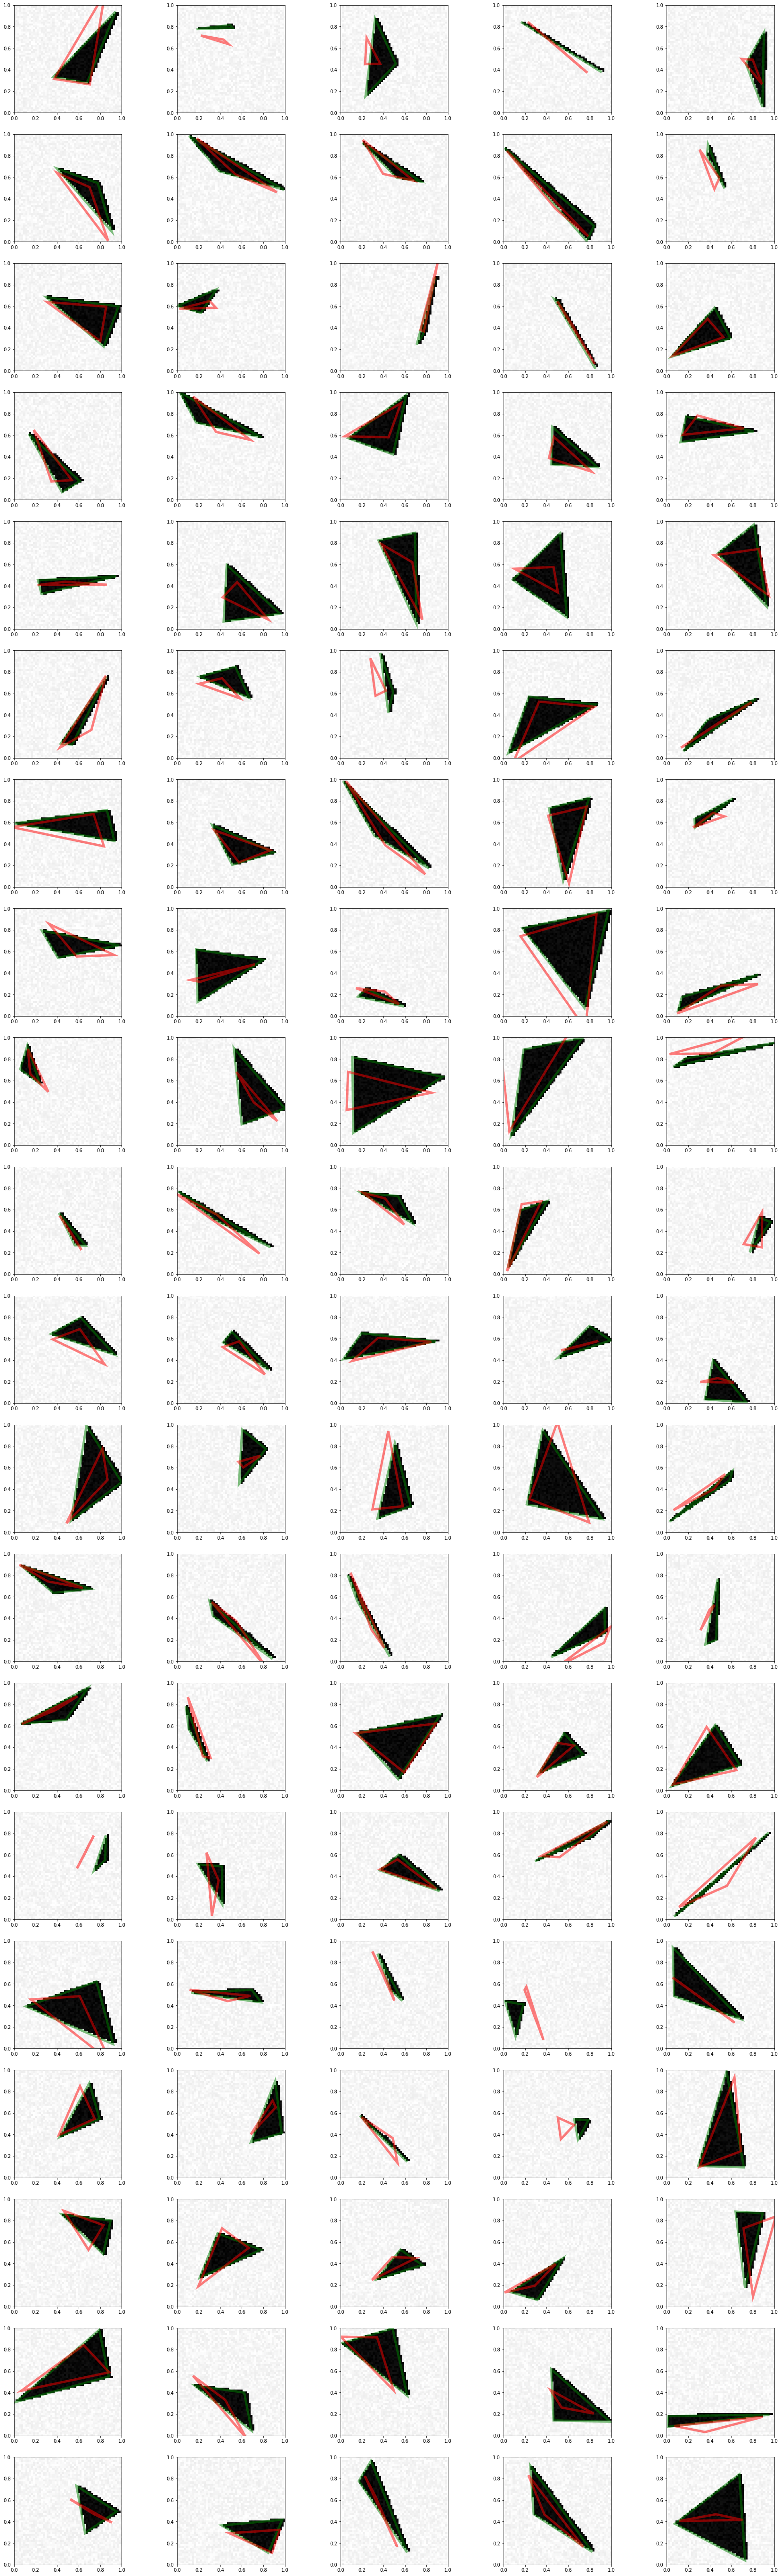

In [101]:
display_multiple_graphs(reg_model,X_test,Y_test,X_test_reshaped)

The results are quite correct on the train set (even work better in some cases than in other). On the test set it is quite similar. Sometimes the network fails completely and sometimes it is able to capture at least two of the three points.

# Denoising

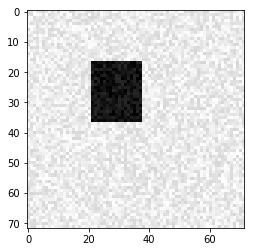

In [4]:
im=generate_a_rectangle(noise=50.0, free_location=True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

In [5]:
X_train_denoising,Y_train_denoising=generate_dataset_classification(300, noise=0.0, free_location=True)

Creating Data: 100%|█████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 67.58it/s]


In [6]:
sigma=0.2
noisy_images=X_train_denoising+sigma*np.random.random(size=X_train_denoising.shape)

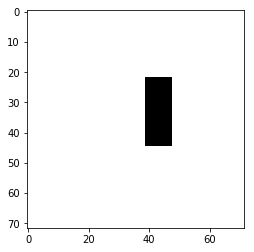

In [7]:
im=X_train_denoising[0].reshape((IMAGE_SIZE,IMAGE_SIZE),)
plt.imshow(im,cmap='gray')

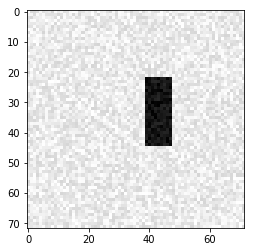

In [8]:
im=noisy_images[0].reshape((IMAGE_SIZE,IMAGE_SIZE),)
plt.imshow(im,cmap='gray')

In [9]:
train_reshaped = np.zeros((X_train_denoising.shape[0],72,72,1))
for i in range(X_train_denoising.shape[0]):
    train_reshaped[i,:,:,:] = X_train_denoising[i].reshape(72,72,1)

In [10]:
noisy_images_reshaped=np.zeros((noisy_images.shape[0],72,72,1))
for i in range(noisy_images.shape[0]):
    noisy_images_reshaped[i,:,:,:] = noisy_images[i].reshape(72,72,1)

In [11]:
def PSNR(y_true, y_pred):
    '''
    Computes the PSNR 'metric' between two images assumed to be in the range [0,1]
    '''
    return 10.0 * K.log(1.0 / (K.mean(K.square(y_pred - y_true)))) / K.log(10.0)

In [12]:
# Build U-Net model
padding = 'same'
inputs = Input((IMAGE_SIZE**2,))

# Reshape layer
r0 = Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE**2,), name='reshape') (inputs)

## Contractive path
# First step : convlayer(72, 72, 16) + dropout + convlayer(72, 72, 16) + maxpool(36, 36, 16)
c1 = Conv2D(16, (3, 3), activation='relu', padding=padding, name='conv1') (r0)
c1 = Dropout(0.1, name='drop1') (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding=padding, name='conv2') (c1)
p1 = MaxPooling2D((2, 2), name='maxpool1') (c1)

# Second step : convlayer(36, 36, 32) + dropout + convlayer(36, 36, 32) + maxpool(18, 18, 32)
c2 = Conv2D(32, (3, 3), activation='relu', padding=padding, name='conv3') (p1)
c2 = Dropout(0.1, name='drop2') (c2)
c2 = Conv2D(32, (3, 3), activation='relu', padding=padding, name='conv4') (c2)
p2 = MaxPooling2D((2, 2), name='maxpool2') (c2)

## Bottom : convlayer(18, 18, 64) + dropout + convlayer(18, 18, 64)
c3 = Conv2D(64, (3, 3), activation='relu', padding=padding, name='conv5') (p2)
c3 = Dropout(0.3, name='drop3') (c3)
c3 = Conv2D(64, (3, 3), activation='relu', padding=padding, name='conv6') (c3)

## Expansive path
# First step : transposedconvlayer(36, 36, 32) + concatenate(36, 36, 64)
u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=padding, name='dconv1') (c3)
u4= concatenate([u4, c2], name='concat1', axis=3)

# Second step : convlayer(36, 36, 32) + dropout + convlayer(36, 36, 32)
c5 = Conv2D(32, (3, 3), activation='relu', padding=padding, name='conv7') (u4)
c5 = Dropout(0.2, name='drop4') (c5)
c5 = Conv2D(32, (3, 3), activation='relu', padding=padding, name='conv8') (c5)

# Third step : transposedconvlayer(72, 722, 16) + concatenate(72, 72, 32)
u6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=padding, name='dconv2') (c5)
u6 = concatenate([u6, c1], name='concat2')

# Fourth step : convlayer(72, 72, 16) + dropout + convlayer(72, 72, 16)
c7 = Conv2D(16, (3, 3), activation='relu', padding=padding, name='conv9') (u6)
c7 = Dropout(0.2, name='drop5') (c7)
c7 = Conv2D(16, (3, 3), activation='relu', padding=padding, name='conv10') (c7)

# Fifth step : convlayer(72, 72, 1)
outputs = Conv2D(1, (1, 1), activation='relu', name='conv11') (c7)

# Reshape layer
r1 = Reshape((IMAGE_SIZE**2,), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='reshape2') (outputs)

hourglass_net = Model(inputs=[inputs], outputs=[r1])
hourglass_net.compile(optimizer='adam', loss='mean_absolute_error', metrics=[PSNR])
hourglass_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5184)         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 72, 72, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 72, 72, 16)   160         reshape[0][0]                    
__________________________________________________________________________________________________
drop1 (Dropout)                 (None, 72, 72, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

In [13]:
import pickle
earlystop = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint('hourglass.h5', verbose=1, save_best_only=True)
results = hourglass_net.fit(noisy_images, X_train_denoising, validation_split=0.2, batch_size=32,
                    epochs=100, callbacks=[checkpoint])
pickle.dump([hourglass_net.history.epoch, hourglass_net.history.history], open('hourglass_history.pkl', 'wb'))

Train on 240 samples, validate on 60 samples
Epoch 1/100
240/240 [==============================] - ETA: 16s - loss: 0.9116 - PSNR: 0.464 - ETA: 10s - loss: 0.8790 - PSNR: 0.743 - ETA: 7s - loss: 0.8425 - PSNR: 1.133 - ETA: 5s - loss: 0.7857 - PSNR: 1.76 - ETA: 3s - loss: 0.7125 - PSNR: 2.66 - ETA: 2s - loss: 0.6597 - PSNR: 3.25 - ETA: 0s - loss: 0.6202 - PSNR: 3.71 - 11s 46ms/step - loss: 0.5979 - PSNR: 4.0613 - val_loss: 0.2487 - val_PSNR: 10.7833

Epoch 00001: val_loss improved from inf to 0.24873, saving model to unet.h5
Epoch 2/100
240/240 [==============================] - ETA: 7s - loss: 0.2301 - PSNR: 10.606 - ETA: 6s - loss: 0.2387 - PSNR: 10.448 - ETA: 5s - loss: 0.2398 - PSNR: 10.463 - ETA: 4s - loss: 0.2336 - PSNR: 10.658 - ETA: 2s - loss: 0.2257 - PSNR: 10.909 - ETA: 1s - loss: 0.2222 - PSNR: 11.027 - ETA: 0s - loss: 0.2208 - PSNR: 11.079 - 10s 41ms/step - loss: 0.2196 - PSNR: 11.1258 - val_loss: 0.1059 - val_PSNR: 14.6382

Epoch 00002: val_loss improved from 0.24873 to 0.

240/240 [==============================] - ETA: 7s - loss: 0.0464 - PSNR: 23.659 - ETA: 6s - loss: 0.0464 - PSNR: 23.736 - ETA: 5s - loss: 0.0459 - PSNR: 23.752 - ETA: 4s - loss: 0.0455 - PSNR: 23.785 - ETA: 2s - loss: 0.0453 - PSNR: 23.827 - ETA: 1s - loss: 0.0453 - PSNR: 23.844 - ETA: 0s - loss: 0.0452 - PSNR: 23.855 - 9s 39ms/step - loss: 0.0452 - PSNR: 23.8434 - val_loss: 0.0726 - val_PSNR: 21.8877

Epoch 00018: val_loss did not improve from 0.06054
Epoch 19/100
240/240 [==============================] - ETA: 7s - loss: 0.0449 - PSNR: 23.847 - ETA: 6s - loss: 0.0442 - PSNR: 23.952 - ETA: 5s - loss: 0.0443 - PSNR: 24.045 - ETA: 4s - loss: 0.0445 - PSNR: 23.999 - ETA: 2s - loss: 0.0444 - PSNR: 24.011 - ETA: 1s - loss: 0.0443 - PSNR: 24.030 - ETA: 0s - loss: 0.0442 - PSNR: 24.046 - 9s 39ms/step - loss: 0.0441 - PSNR: 24.0540 - val_loss: 0.0628 - val_PSNR: 23.0380

Epoch 00019: val_loss did not improve from 0.06054
Epoch 20/100
240/240 [==============================] - ETA: 7s - loss:

240/240 [==============================] - ETA: 8s - loss: 0.0311 - PSNR: 27.023 - ETA: 6s - loss: 0.0308 - PSNR: 27.163 - ETA: 5s - loss: 0.0308 - PSNR: 27.113 - ETA: 4s - loss: 0.0307 - PSNR: 27.142 - ETA: 3s - loss: 0.0308 - PSNR: 27.106 - ETA: 1s - loss: 0.0307 - PSNR: 27.159 - ETA: 0s - loss: 0.0306 - PSNR: 27.171 - 10s 43ms/step - loss: 0.0307 - PSNR: 27.1770 - val_loss: 0.0536 - val_PSNR: 24.6045

Epoch 00035: val_loss did not improve from 0.05341
Epoch 36/100
240/240 [==============================] - ETA: 8s - loss: 0.0298 - PSNR: 27.516 - ETA: 7s - loss: 0.0299 - PSNR: 27.387 - ETA: 5s - loss: 0.0300 - PSNR: 27.361 - ETA: 4s - loss: 0.0300 - PSNR: 27.348 - ETA: 3s - loss: 0.0299 - PSNR: 27.379 - ETA: 1s - loss: 0.0300 - PSNR: 27.380 - ETA: 0s - loss: 0.0300 - PSNR: 27.360 - 10s 43ms/step - loss: 0.0300 - PSNR: 27.3723 - val_loss: 0.0569 - val_PSNR: 24.1496

Epoch 00036: val_loss did not improve from 0.05341
Epoch 37/100
240/240 [==============================] - ETA: 8s - los

Epoch 00051: val_loss did not improve from 0.03145
Epoch 52/100
240/240 [==============================] - ETA: 8s - loss: 0.0181 - PSNR: 31.186 - ETA: 7s - loss: 0.0181 - PSNR: 31.451 - ETA: 5s - loss: 0.0179 - PSNR: 31.530 - ETA: 4s - loss: 0.0178 - PSNR: 31.551 - ETA: 3s - loss: 0.0178 - PSNR: 31.546 - ETA: 1s - loss: 0.0179 - PSNR: 31.498 - ETA: 0s - loss: 0.0178 - PSNR: 31.560 - 10s 43ms/step - loss: 0.0178 - PSNR: 31.5778 - val_loss: 0.0303 - val_PSNR: 29.5748

Epoch 00052: val_loss improved from 0.03145 to 0.03033, saving model to unet.h5
Epoch 53/100
240/240 [==============================] - ETA: 8s - loss: 0.0178 - PSNR: 31.260 - ETA: 7s - loss: 0.0178 - PSNR: 31.542 - ETA: 5s - loss: 0.0174 - PSNR: 31.526 - ETA: 4s - loss: 0.0173 - PSNR: 31.682 - ETA: 3s - loss: 0.0172 - PSNR: 31.728 - ETA: 1s - loss: 0.0171 - PSNR: 31.783 - ETA: 0s - loss: 0.0171 - PSNR: 31.853 - 10s 44ms/step - loss: 0.0170 - PSNR: 31.8897 - val_loss: 0.0277 - val_PSNR: 30.3016

Epoch 00053: val_loss impro

240/240 [==============================] - ETA: 8s - loss: 0.0041 - PSNR: 39.094 - ETA: 7s - loss: 0.0040 - PSNR: 38.690 - ETA: 5s - loss: 0.0039 - PSNR: 38.545 - ETA: 4s - loss: 0.0038 - PSNR: 38.575 - ETA: 3s - loss: 0.0038 - PSNR: 38.363 - ETA: 1s - loss: 0.0039 - PSNR: 38.089 - ETA: 0s - loss: 0.0039 - PSNR: 38.082 - 10s 43ms/step - loss: 0.0039 - PSNR: 38.1422 - val_loss: 0.0041 - val_PSNR: 41.7578

Epoch 00068: val_loss improved from 0.00438 to 0.00412, saving model to unet.h5
Epoch 69/100
240/240 [==============================] - ETA: 8s - loss: 0.0035 - PSNR: 38.092 - ETA: 7s - loss: 0.0034 - PSNR: 38.071 - ETA: 5s - loss: 0.0034 - PSNR: 38.201 - ETA: 4s - loss: 0.0034 - PSNR: 38.246 - ETA: 3s - loss: 0.0034 - PSNR: 38.269 - ETA: 1s - loss: 0.0035 - PSNR: 38.275 - ETA: 0s - loss: 0.0035 - PSNR: 38.194 - 10s 43ms/step - loss: 0.0034 - PSNR: 38.2307 - val_loss: 0.0050 - val_PSNR: 41.2114

Epoch 00069: val_loss did not improve from 0.00412
Epoch 70/100
240/240 [==================

240/240 [==============================] - ETA: 8s - loss: 0.0032 - PSNR: 40.227 - ETA: 7s - loss: 0.0030 - PSNR: 39.381 - ETA: 5s - loss: 0.0022 - PSNR: 39.857 - ETA: 4s - loss: 0.0022 - PSNR: 40.068 - ETA: 3s - loss: 0.0023 - PSNR: 40.047 - ETA: 1s - loss: 0.0021 - PSNR: 40.199 - ETA: 0s - loss: 0.0022 - PSNR: 40.004 - 10s 43ms/step - loss: 0.0023 - PSNR: 40.1013 - val_loss: 0.0023 - val_PSNR: 45.0527

Epoch 00085: val_loss did not improve from 0.00080
Epoch 86/100
240/240 [==============================] - ETA: 8s - loss: 0.0027 - PSNR: 40.662 - ETA: 7s - loss: 0.0017 - PSNR: 40.468 - ETA: 5s - loss: 0.0017 - PSNR: 40.854 - ETA: 4s - loss: 0.0017 - PSNR: 41.063 - ETA: 3s - loss: 0.0016 - PSNR: 40.704 - ETA: 1s - loss: 0.0015 - PSNR: 40.688 - ETA: 0s - loss: 0.0015 - PSNR: 40.498 - 10s 43ms/step - loss: 0.0014 - PSNR: 40.5286 - val_loss: 0.0012 - val_PSNR: 45.9508

Epoch 00086: val_loss did not improve from 0.00080
Epoch 87/100
240/240 [==============================] - ETA: 8s - los

NameError: name 'unet' is not defined

In [14]:
pickle.dump([hourglass_net.history.epoch, hourglass_net.history.history], open('hourglass_net_history.pkl', 'wb'))

In [15]:
hourglass_net.save('hourglass_net.h5')

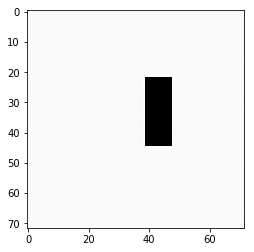

In [37]:
im_pred=hourglass_net.predict(noisy_images[0].reshape((1,5184)))
plt.imshow(im_pred.reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')

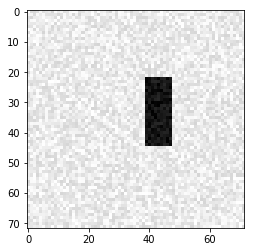

In [39]:
plt.imshow(noisy_images[0].reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')

The hourglass network work very well and the quality of the denoising is very impressive. This is thanks by the fact that the images to denoise have quite simple structures (black or white pixels).